In [2]:
import re
import csv

def extrair_para_csv(entrada, saida):
    with open(entrada, 'r') as arq:
        linhas = arq.readlines()

    padrao_linha = re.compile(r"\[\s*\d+\]\s+([\d\.]+-[\d\.]+)\s+sec\s+([\d\.]+)\s+MBytes\s+([\d\.]+)\s+Mbits/sec")
    dados = []
    contador = 1
    novo_teste = True  # Usado para marcar o início de um novo bloco de teste

    for linha in linhas:
        if "Running TCP test between" in linha:
            # Início de novo teste
            if dados and dados[-1] != []:
                dados.append([])  # linha em branco como separador
            contador = 1
            continue

        match = padrao_linha.search(linha)
        if match:
            intervalo = match.group(1)
            if intervalo.startswith("0.0000-") and contador > 1:
                continue
            transferencia = match.group(2)
            banda = match.group(3)
            dados.append([contador, transferencia, banda])
            contador += 1

    with open(saida, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["id", "transferencia", "banda"])
        for linha in dados:
            writer.writerow(linha)  # escreve dados normalmente (inclui separações)

# Executa o script
extrair_para_csv("filtrado.txt", "saida.csv")


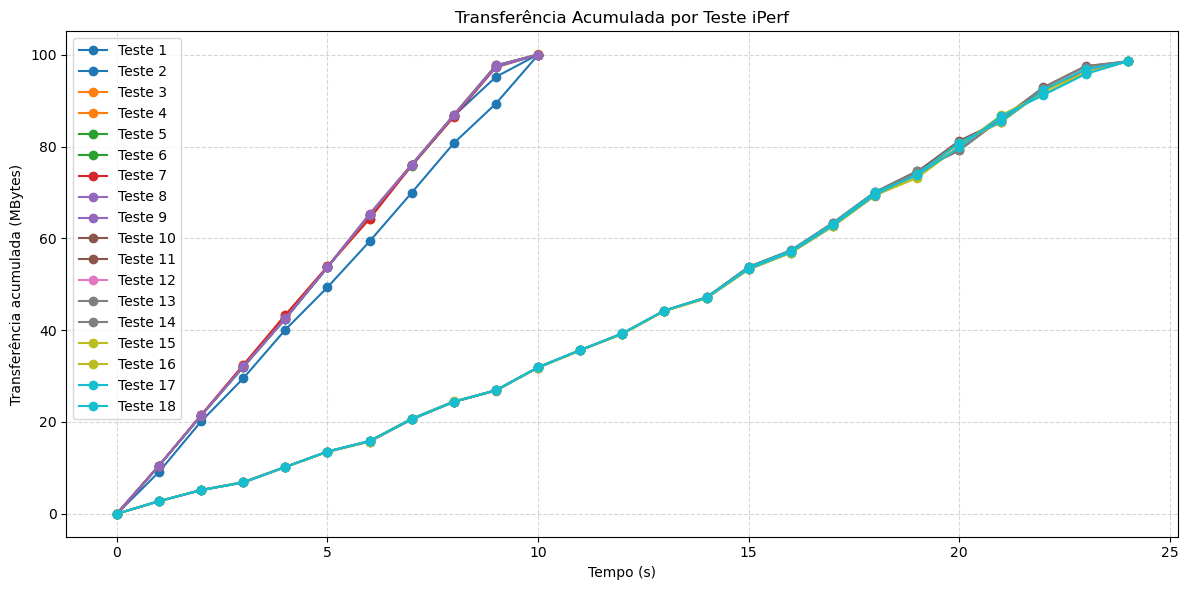

In [6]:
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def gerar_grafico_multicolor(csv_path):
    testes = []
    teste_atual = []
    tempo = 0

    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # pula cabeçalho

        for row in reader:
            if not row:  # separador de teste
                if teste_atual:
                    testes.append(teste_atual)
                    teste_atual = []
                    tempo = 0
                continue
            try:
                transferencia = float(row[1])
                tempo += 1
                if not teste_atual:
                    teste_atual.append((0, 0))  # garante que começa do zero
                acumulado = teste_atual[-1][1] + transferencia
                teste_atual.append((tempo, acumulado))
            except:
                continue

        # adicionar último teste se não terminou com linha em branco
        if teste_atual:
            testes.append(teste_atual)

    # Plotando com cores diferentes
    plt.figure(figsize=(12, 6))
    cores = cm.get_cmap('tab10', len(testes))

    for i, teste in enumerate(testes):
        x = [p[0] for p in teste]
        y = [p[1] for p in teste]
        plt.plot(x, y, marker='o', label=f'Teste {i + 1}', color=cores(i))

    plt.title("Transferência Acumulada por Teste iPerf")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Transferência acumulada (MBytes)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("grafico_multicolor_teste_iperf.png")
    plt.show()

# Executar com seu arquivo
gerar_grafico_multicolor("saida.csv")
